In [155]:
import pandas as pd
# from fbprophet import Prophet
import pandas
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
import numpy as np
from praveganb.pravega_stream import UnindexedStream
import seaborn as sns
import pytz
import grpc
import imp
import pravega.grpc_gateway as pravega
from datetime import datetime, timedelta
import json
%matplotlib inline

gateway = '10.243.37.96:80'
scope = 'alerts'
stream = 'snmp-enriched'

pravega_channel = grpc.insecure_channel(gateway, options=[
        ('grpc.max_receive_message_length', 9*1024*1024),
    ])
pravega_client = pravega.grpc.PravegaGatewayStub(pravega_channel)

snmpdata = UnindexedStream(scope='alerts', stream='snmp-enriched', pravega_client=pravega_client)
events = snmpdata.read_events_from_stream(stop_at_tail=True)

df = pd.DataFrame(list(events))

df['timeStrStamp'] = pandas.to_datetime(df['receivedTimestamp'],unit="ms",utc=True)

minTime = (datetime.now() - timedelta(hours = 8)).timestamp() * 1000

df = df[(df.receivedTimestamp > minTime )]

# Severity and Message By Device for Past Two Hours

In [156]:
df[['deviceMibModule','notifyLevel', 'notifyMessage']].value_counts()

deviceMibModule  notifyLevel  notifyMessage                                                                                               
SCALEIO-MIB      5            System.Credentials.MDM_CREDENTIALS_ARE_NOT_CONFIGURED                                                           512
                 2            Esrs.Esrs.NOT_REGISTERED                                                                                        442
ISILON-TRAP-MIB  0            SW_TEST_EVENT                                                                                                    48
iDRAC-SMIv2      3            User root via IP 10.135.20.240 requested state / configuration change to SNMP Traps Configuration using GUI.      2
                              User root via IP 10.135.20.240 requested state / configuration change to SNMP Settings using GUI.                 2
                              User root via IP 10.135.20.240 requested state / configuration change to IPMI Settings using GUI.    

# Notify Message for Past Two Hours

<AxesSubplot:>

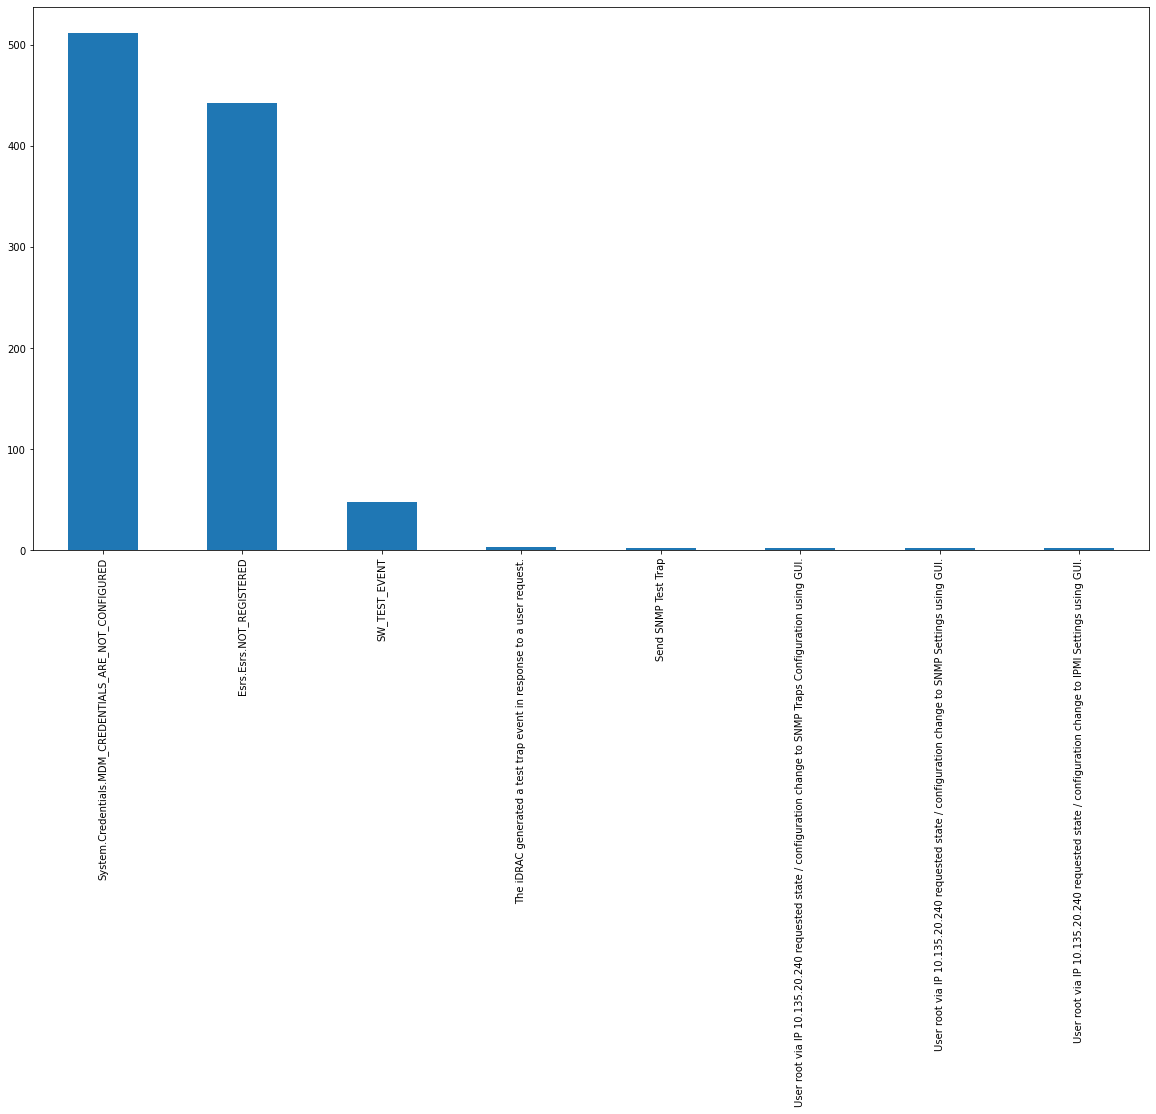

In [157]:
mess = df.notifyMessage.value_counts()
mess.plot(kind='bar', figsize=(20,10))

# Device Type for Past Two Hours

<AxesSubplot:>

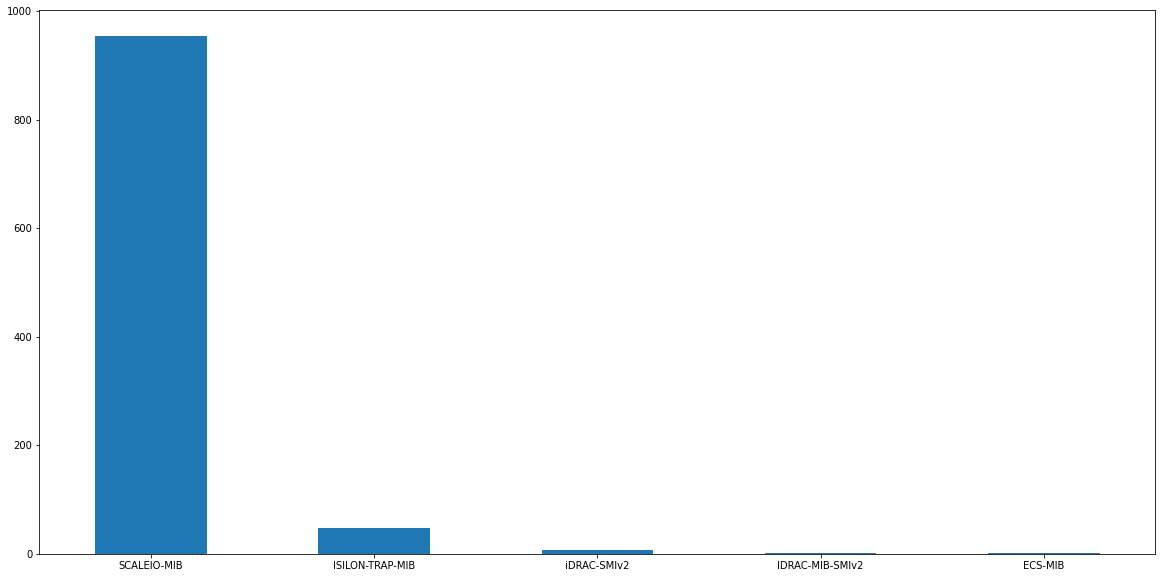

In [158]:
dev = df.deviceMibModule.value_counts()
dev.plot(kind='bar', figsize=(20,10), rot=0)

# Counter Failure Message By Specific Name(Esrs.Esrs.NOT_REGISTERED) for Past Two Hours

In [159]:
expand_df = pd.json_normalize(df['trap'], meta=['receivedTimestamp'])
df.reset_index(drop=True,inplace=True)
df = pd.concat([df, expand_df], axis=1)
failure_msg = 'Esrs.Esrs.NOT_REGISTERED'
len(df[df['notifyMessage']==failure_msg])

442